# Lecutre 17 and 18 Post-lecture quiz

In this post-lecture quiz, we will practice lecture materials for lecture 17 and 18.

* Lecture 17: Expected sensitivity 

There are 2 tasks in this section.
We will use Likelihood ratio method for Discovery Test, and Upper limit calculation.
First, we will evaluate the Expected discovery sensitivity using Frequentist approach.
Second, we will perform statistical tests on the same pseudo-data in two approaches: Bayesian vs Frequentist.

* Lecture 18: Machine Learning: un-supervised

There are 3 tasks in this section: We will practice K-Means clustering, Principle Component Analysis and t-SNE.

To work on Lecture 18 quiz, you have to install following tools
* sklearn: https://scikit-learn.org/stable/install.html
* PyTorch: https://www.geeksforgeeks.org/how-to-install-pytorch-on-macos/
    * torch
    * torchvision
    * torchaudio

## Lecture 17 Expected sensitivity

Let's start with preparing pseudo-data composed of a Gaussian signal and exponential background.

In [1]:
# definition of PDF
import matplotlib.pyplot as plt
import iminuit.minimize as minimize
from tqdm import tqdm

import numpy as np
import scipy
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import poisson
# First we have to define PDF models
def norm_S(x,MH,Width):
    return norm.pdf(x,MH,Width)

def norm_B(x,alpha):
    ainv=1./alpha
    r = expon.pdf(ainv*(x-xmin))
    c = r*ainv/(1.-expon.pdf(ainv*(xmax-xmin)))
    #print(x,alpha,r,c)
    return c 

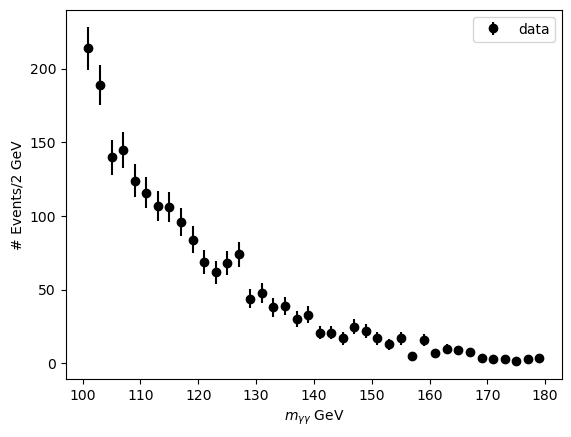

In [2]:
# Truth parameter for this exercise
# A resonance with mass peak 125.5 GeV and width 2GeV
# The decay constant of the exponential background is 20
MH_truth = 125.5
Width_truth=2
Alpha_truth=20

# The signal yield is 20 and the background yield is 2000
Ns_truth = 20
Nb_truth = 2000

#We will study the mass shape between 100GeV and 180GeV in 40 bins
xmin = 100
xmax = 180
nbins= 40
bins = np.linspace(xmin, xmax, nbins+1)
binCenter = 1/2 *(bins[1:] + bins[:-1])
binWidth = bins[1]-bins[0]
Ns_predict = Ns_truth*binWidth*norm_S(binCenter,MH_truth,Width_truth)
Nb_predict = Nb_truth*binWidth*norm_B(binCenter,Alpha_truth)
Ns_and_Nb  = Ns_predict+Nb_predict

#set random seed to guarantee reproducibility
np.random.seed(seed=6)

Ndata = np.random.poisson(Ns_and_Nb)

fig =  plt.figure()
plt.cla()
plt.errorbar(binCenter, Ndata, Ndata ** 0.5, fmt="ok",label='data')
#plt.bar(binCenter, Ns_and_Nb, color='orange', label='s+b')
#plt.bar(binCenter, Nb_predict, color='b', label='b only')
plt.xlabel("$m_{\gamma\gamma}$ GeV")
plt.ylabel("# Events/%.1g GeV"%binWidth)
plt.legend()
plt.show()

# Likelihood definition


The likelihood is a joint product of Poisson probability from each bin

$L(\mu|x)=\prod_i^{M}\frac{ (\mu S_i+ \theta B_i)^{n_i}}{n!} e^{-(\mu S_i+ \theta B_i)}$,

where $\mu$ is the signal strength and $\theta$ is the background strength.

The binned log likelihood can be approximated as:

$-2 \mathrm{ln} L(\mu|x) = -2 \sum_i^{M} [ {n_i} \mathrm{ln} (\mu S_i+\theta B_i) -(\mu S_i+ \theta B_i) ]$




In [3]:
def neg_binned_logL(pars,N_observe,Ns,Nb):
    mu=pars[0]
    bkg=pars[1]
    N_predict  = mu*Ns+bkg*Nb

    output= -2*np.sum( [ n_obs*np.log(n_predict) - n_predict for n_obs, n_predict in zip(N_observe, N_predict) ] )
    return output


The test statistics for discovery test is defined as:

$ q_0 = \frac{L(\mu=0, \hat{\hat{\theta}})}{L(\hat{\mu},\hat{\theta})}$,
where $\hat{\mu}$ and $\hat{\theta}$ are the best fit values of signal strength and background strength, respectively.
$\hat{\hat{\theta}}$ is the best fit of background strength at $\mu=0$ (background-only model).


In [5]:
#
# defin q_0 test statistics
# It performs two fits:
# - first fit with background-only model 
# - second fit with float mu and theta
#
# This function returns three outputs:
# - q_0
# - first fit output
# - second fit output
#
def q0(N_data,Ns,Nb):
    #fix mu=0
    bkg_init=np.sum(N_data)/np.sum(Nb)
    bkg_max=2*np.sum(N_data)/np.sum(Nb)
    
    x0=[0,bkg_init]
    bounds=[[0,0],[0,bkg_max]]
    outfit0 = minimize(fun=neg_binned_logL,x0=x0,args=[N_data, Ns, Nb],bounds=bounds)

    #float mu
    mu_init=abs(np.sum(N_data-Nb))/np.sum(Ns)
    mu_max=2*np.sum(N_data)/np.sum(Ns)
    
    x0=[mu_init,bkg_init]
    bounds=[[0,mu_max],[0,bkg_max]]
    outfit1 = minimize(fun=neg_binned_logL,x0=x0,args=[N_data, Ns, Nb],bounds=bounds)
     
    q0_test=0
    if(outfit1.x[0] > 0):
        num=neg_binned_logL(outfit0.x,N_data, Ns, Nb)
        den=neg_binned_logL(outfit1.x,N_data, Ns, Nb)
        q0_test=num-den
    return [q0_test, outfit0.x, outfit1.x]


The test statistics for upper limit is defined as:

$ q_{\mu} = \frac{L(\mu, \hat{\hat{\theta}})}{L(\hat{\mu},\hat{\theta})}$,
where $\hat{\mu}$ and $\hat{\theta}$ are the best fit values of signal strength and background strength, respectively.
$\hat{\hat{\theta}}$ is the best fit of background strength at $\mu$ (alternative hypothesis with $\mu$ given).

In [7]:
# define q_mu test statistics
# It performs two fits:
# - first fit fixed mu 
# - second fit float mu and theta
#
# This function returns three output
# - q_mu
# - first fit output
# - second fit output
#
def qmu(mu,N_data,Ns,Nb):

    #fix mu
    bkg_init=np.sum(N_data)/np.sum(Nb)
    bkg_max=2*np.sum(N_data)/np.sum(Nb)
    
    x0=[mu,bkg_init]
    bounds=[[mu,mu],[0,bkg_max]]
    outfit0 = minimize(fun=neg_binned_logL,x0=x0,args=[N_data, Ns, Nb],bounds=bounds)

    #float mu
    mu_init=abs(np.sum(N_data-Nb))/np.sum(Ns)
    mu_max=2*np.sum(N_data)/np.sum(Ns)
    
    x0=[mu_init,bkg_init]
    bounds=[[0,mu_max],[0,bkg_max]]
    outfit1 = minimize(fun=neg_binned_logL,x0=x0,args=[N_data, Ns, Nb],bounds=bounds)
    
    #print(outfit0)
    #print(outfit1)
    # qmu_test is only none-zero when second fit signal strength 
    # is less than tested signal strength
    qmu_test=0
    if(outfit1.x[0] < mu):
        num=neg_binned_logL(outfit0.x,N_data, Ns, Nb)
        den=neg_binned_logL(outfit1.x,N_data, Ns, Nb)
        qmu_test=num-den
    return [qmu_test, outfit0.x, outfit1.x]

## Part 1 Calculate expected discovery significance (Frequentist approach)

Step 1. Generate signal+background toy experiments with $\mu=1$ to obtain median of the $q_{0,toy}$ if signal exists.

Step 2. Generate background-only toy experiments with $\mu=0$ to calculate p-value. p-value is fraction of $q_0$ under background-only model with the value greater or equal to the median $q_{0,toy}$. 

In [37]:
#set random seed to guarantee reproducibility
np.random.seed(seed=7)

# Generate 10K toy experiments based on signal and background hypothesis
# Perform discovery test on each toy experiment to obtain q_0 distribtuion
Ntoys=10000
h0_expect=np.zeros(Ntoys)
for i in tqdm(range(Ntoys)):
    toy_hist = np.random.poisson(Ns_and_Nb)
    q0_output,output0,output1=q0(toy_hist,Ns_predict,Nb_predict)
    h0_expect[i]=q0_output

100%|██████████| 10000/10000 [02:35<00:00, 64.45it/s]


In [42]:
print(len(h0_expect))

10000


In [9]:
#set random seed to guarantee reproducibility
np.random.seed(seed=8)


# Generate toy experiments based on background only model
Ntoys=10000
h0_test=np.zeros(Ntoys)
for i in tqdm(range(Ntoys)):
    toy_hist = np.random.poisson(Nb_predict)
    q0_out,output0,output1=q0(toy_hist,Ns_predict,Nb_predict)
    h0_test[i]=q0_out

100%|██████████| 10000/10000 [02:26<00:00, 68.17it/s]


Expected $q_0(\mu=1)$ : 1.68
Expected pvalue: 0.098
Expected Z-score(1 side)=1.29


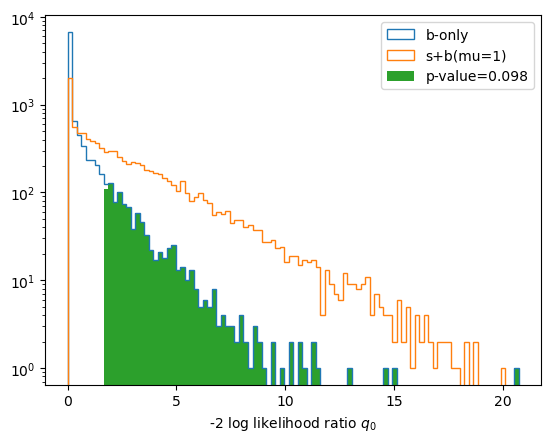

In [33]:
# Calculate expected p-value and expected significance
# Step 1. Find median of the q_0,toy distribution with predicted signal and background
q_med=np.median(h0_expect)

# Step 2. Compute p-value of the q_0,toy using background-only q_0 distribution
pvalue=len(h0_test[h0_test>q_med])/len(h0_test)
Zscore= scipy.stats.norm.ppf(1-pvalue) 

print('Expected $q_0(\mu=1)$ : %.2f'%q_med)
print('Expected pvalue: %.3f'%pvalue)
print('Expected Z-score(1 side)=%.2f'%Zscore)


Xmin=np.min(h0_test)
Xmax=np.max(h0_test)

plt.yscale('log')
plt.hist(h0_test,bins=100,range=[Xmin,Xmax],histtype='step',label='b-only')
plt.hist(h0_expect,bins=100,range=[Xmin,Xmax],histtype='step',label='s+b(mu=1)')
plt.hist(h0_test[h0_test>q_med],bins=100,range=[Xmin,Xmax],label='p-value=%.2g'%pvalue)

plt.xlabel("-2 log likelihood ratio $q_0$")
plt.legend()
plt.show()

## Part 2a Bayesian discovery test

Let's compute the observed significance using the Bayesian approach:
$\mathrm{p-value}= \sqrt{q_0}$


<IPython.core.display.Math object>

<IPython.core.display.Math object>

q0: 4.207792790033636


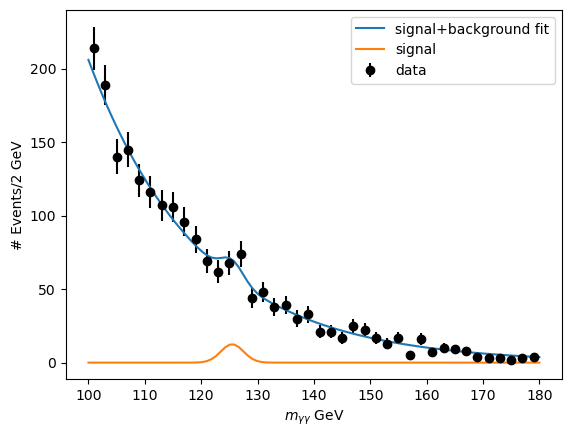

In [15]:
from IPython.display import display, Math

q0_data,outfit0,outfit1=q0(Ndata,Ns_predict,Nb_predict)

xspace = np.linspace(xmin,xmax,100)
NbOnly_fit = outfit0[1]*Nb_truth*binWidth*norm_B(xspace,Alpha_truth)
Ns_fit = outfit1[0]*Ns_truth*binWidth*norm_S(xspace,MH_truth,Width_truth)
Nb_fit = outfit1[1]*Nb_truth*binWidth*norm_B(xspace,Alpha_truth)

display(Math(r'\mathrm{Bkg-only\; fit:} \hat{\mu}=%.2f\;  \hat{\hat{\theta}}=%.2f'%(outfit0[0],outfit0[1])))
display(Math(r'\mathrm{Sig+Bkg\; combined\; fit:} \hat{\mu}=%.2f\;  \hat{\theta}=%.2f'%(outfit1[0],outfit1[1])))
print("q0:",q0_data)

fig =  plt.figure()
plt.cla()
#plt.hist(masses,bins=nbins,range=(xmin,xmax),histtype='step',density=False)
plt.errorbar(binCenter, Ndata, Ndata ** 0.5, fmt="ok",label='data')
#plt.plot(xspace,NbOnly_fit,label='background-only fit')

plt.plot(xspace,Ns_fit+Nb_fit,label='signal+background fit')
plt.plot(xspace,Ns_fit,label='signal')
#plt.axis([100,180,0,0.05])
plt.xlabel("$m_{\gamma\gamma}$ GeV")
plt.ylabel("# Events/%.1g GeV"%binWidth)

#plt.title("$\hat{m}_{H}=%.2f,\hat{f}_{S}=%.3f,\hat{\\alpha}=%.2f$"%(res.x[0],res.x[1],res.x[2]))
plt.legend()
plt.show()

Let's plot the -2 log likelihood as function of $\mu$. In each $\mu$, the background $\theta$ is set to the corresponding best fit value.

100%|██████████| 102/102 [00:01<00:00, 71.49it/s]

Best fit $\mu$=1.57 $theta=1.01$
p-value Z=\sqrt(q_0): 0.0206
Significance Z=\sqrt(q_0): 2.0512905181942505


Text(0, 0.5, '-2 log $L/L_{max}$')

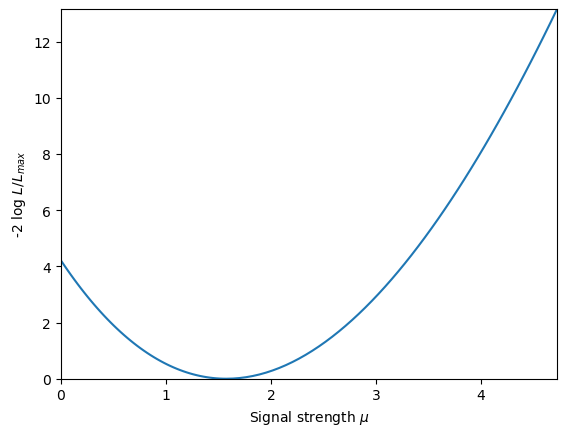

In [27]:
# TODO Error in p-value calculation here (should be <1). Swapped it with frequentist value for now so no NaNs show up.
# First, let's get the best fit value of signal and background strength mu, theta
q0_data,outfit0,outfit1=q0(Ndata,Ns_predict,Nb_predict)
pvalue=len(h0_test[h0_test>q0_data])/len(h0_test)
zscore = (q0_data)**.5
#or use: scipy.stats.norm.ppf(1-pvalue) to get equivalent result.

# Define 102 points, 
# The first 51 point is between 0 and best fit mu.
# The second 51 points are between besft fit mu and factor of 3 of the best fit mu.
Npoints =100
xspace1 = np.linspace(0,outfit1[0],51)
xspace2 =np.linspace(outfit1[0],outfit1[0]*3,51)
xspace = [*xspace1, *xspace2]


# scan mu to compute each q_mu
qmulist = np.zeros(len(xspace))

for i in tqdm(range(len(xspace))):
    qmu_data,outfit0,outfit1=qmu(xspace[i],Ndata,Ns_predict,Nb_predict)
    den = neg_binned_logL(outfit0,Ndata, Ns_predict,Nb_predict)
    num = neg_binned_logL(outfit1,Ndata, Ns_predict,Nb_predict)
    qmulist[i]=den-num

print("Best fit $\mu$=%.2f $theta=%.2f$"%(outfit1[0],outfit1[1]))
print("p-value Z=\sqrt(q_0):", pvalue)
print("Significance Z=\sqrt(q_0):", zscore)
plt.plot(xspace,qmulist,label='likelihood')
plt.xlim(xspace[0],xspace[-1])
plt.ylim(0,np.max(qmulist))

plt.xlabel('Signal strength $\mu$')
plt.ylabel('-2 log $L/L_{max}$')

## Part 2b Bayesian Upper limit Credibility Level

The significance is less than 5$\sigma$ which fails the discovery test.
We can calculate upper limit using Bayesian approach. It is 95% probablity for $\mu$ to be less or equal to $\mu_{obs}$.

$$CL = \frac{\int_{0}^{\mu_{95\%}} L(\mu|x) d\mu} {\int_{0}^{\infty} L(\mu|x) d\mu}$$

95% CL Upper Limit:  2.8340559420089937


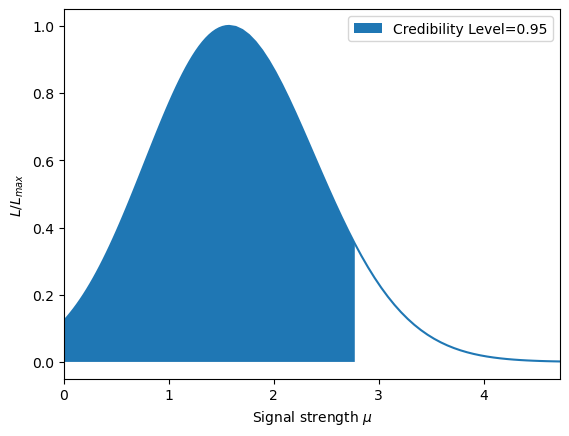

In [23]:
# Task 1 Convert the binned log likelihood to the likelihood and calculate 95% upper limit
#
CL=0.95
LHList = np.exp(-0.5 * qmulist)
sumLH=np.sum(LHList)
sumL=0
idx95=0
for i in range(len(LHList)):
    sumL += LHList[i]/sumLH
    idx95=i
    if(sumL >= 0.950):
        break

print("95% CL Upper Limit: ",xspace[idx95])
fig, ax = plt.subplots()
ax.plot(xspace,LHList)
ax.fill_between(xspace[0:idx95],0,LHList[0:idx95],label='Credibility Level=%.2f'%CL)
plt.xlim(xspace[0],xspace[-1])
plt.xlabel('Signal strength $\mu$')
plt.ylabel('$L/L_{max}$')
plt.legend()

## Part 3a: Frequentist Discovery test

We will generate background-only toy experiments and count the fraction of $q_0$ test statistics less or equal to the observed $q_{0,obs}.$ 

q0: 4.207792790033636
$\sqrt{q0}$: 2.0512905181942505
pvalue: 0.0206
Z-score(1 side)=2.04
The frequentist p-value is similar to Bayesian p-value.


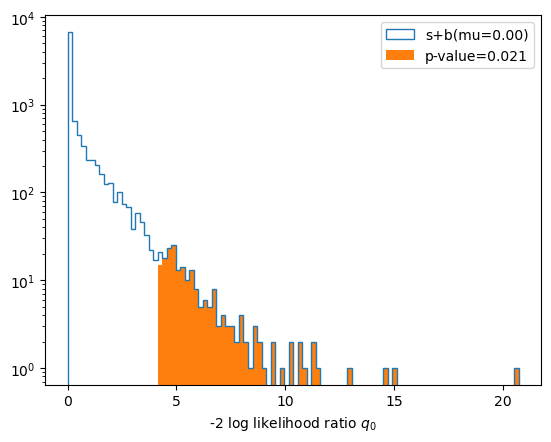

In [29]:
# Calculate p-value
mu=0
q0_data,output0,output1=q0(Ndata,Ns_predict,Nb_predict)

Xmin=np.min(h0_test)
Xmax=np.max(h0_test)

pvalue=len(h0_test[h0_test>q0_data])/len(h0_test)

print('q0:', q0_data)
print('$\sqrt{q0}$:', (q0_data)**.5)
print('pvalue:',pvalue)
print('Z-score(1 side)=%.2f'%scipy.stats.norm.ppf(1-pvalue))
print('The frequentist p-value is similar to Bayesian p-value.')

plt.yscale('log')
plt.hist(h0_test,bins=100,range=[Xmin,Xmax],histtype='step',label='s+b(mu=%.2f)'%mu)
plt.hist(h0_test[h0_test>q0_data],bins=100,range=[Xmin,Xmax],label='p-value=%.2g'%pvalue)

plt.xlabel("-2 log likelihood ratio $q_0$")
plt.legend()
plt.show()

## Part 3b Calculate Frequentist upper limit.

The 95% Confidence Level upper limit $\mu_{95}$ is calculated through the procedure:
1. Generate signal+background toy experiments with $\mu_{95}$.
2. Calculate p-value by counting fraction of the $q_{\mu}$ less or equal to $q_{\mu_{95}}$.
3. The 95% CL means p-value is 0.05.


In [45]:
# Task 2: define a function to compute the p-value of qmu.

Ntoys=10000
def qmu_pvalue(mu,Ndata,Ns_predict,Nb_predict):
    N_predict = mu*Ns_predict+Nb_predict

    hmu_expect=np.zeros(Ntoys)
    for i in tqdm(range(Ntoys)):
        # Generate signal (mu)+background toy experiment
        toy_hist = np.random.poisson(N_predict)
        # Compute qmu of each toy experiment
        qmu_output,output0,output1=qmu(mu,toy_hist,Ns_predict,Nb_predict)
        hmu_expect[i]=qmu_output

    # compute qmu of pseudo-data
    qmu_data,output0,output1=qmu(mu,Ndata,Ns_predict,Nb_predict)

    # calculate fraction of toy experiments with qmu greater or equal to the qmu of pseudo-data
    pvalue= len(hmu_expect[hmu_expect>qmu_data])/len(hmu_expect)
    return [pvalue,hmu_expect]

In [46]:
# Define a function which performs binary search to look for 95% Confidence Level limit
def CalUpperLimit(alpha,N_data,Ns_predict,Nb_predict):

    #Search mu_95 between best fit of strength mu and mu+2 Z, Z=sqrt{q_0,obs}
    q0_output,output0,output1=q0(N_data,Ns_predict,Nb_predict)
    
    high=output1[0]
    low=high+2* q0_output**.5
    print("high p-value \mu=%.2f low p-value \mu=%.3f"%(high,low))

    pval_UL=1
    mu_UL=(high+low)/2
    qmu_UL=np.zeros(Ntoys)

    # Perform binary search within 0.002 range of target p-value 
    while True:
        mu_UL=(high+low)/2
        pval_UL, qmu_UL=qmu_pvalue(mu_UL,N_data,Ns_predict,Nb_predict)
        print("\mu=%.3f p-value=%.3f"%(mu_UL,pval_UL))
        if (abs(high - low)<0.002) or (abs(pval_UL-alpha)<0.002):
            break

        if pval_UL>alpha :
            high=mu_UL
        else:
            low=mu_UL

    return (mu_UL, qmu_UL, pval_UL)

In [47]:
# Execute function to search for 95% CL limit of signal strength

mu_UL, qmu_UL, pval_UL=CalUpperLimit(0.05,Ndata,Ns_predict,Nb_predict)

high p-value \mu=1.57 low p-value \mu=5.677


100%|██████████| 10000/10000 [01:51<00:00, 89.59it/s]


\mu=3.626 p-value=0.008


100%|██████████| 10000/10000 [01:46<00:00, 93.50it/s]


\mu=2.600 p-value=0.105


100%|██████████| 10000/10000 [01:47<00:00, 92.59it/s]


\mu=3.113 p-value=0.035


100%|██████████| 10000/10000 [01:49<00:00, 91.52it/s]


\mu=2.857 p-value=0.064


100%|██████████| 10000/10000 [01:51<00:00, 89.70it/s]


\mu=2.985 p-value=0.040


100%|██████████| 10000/10000 [01:48<00:00, 91.94it/s]


\mu=2.921 p-value=0.054


100%|██████████| 10000/10000 [02:07<00:00, 78.25it/s]

\mu=2.953 p-value=0.050


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

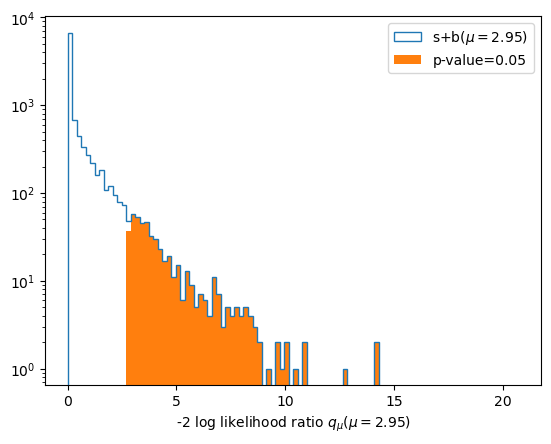

In [48]:
# Print results

qmu_data,output0,output1=qmu(mu_UL,Ndata,Ns_predict,Nb_predict)
pvalue=len(qmu_UL[qmu_UL>qmu_data])/len(qmu_UL)

display(Math(r'\mathrm{\mu+Bkg\; fit:} \mu_{95}=%.2f\;  \hat{\hat{\theta}}=%.2f'%(output0[0],output0[1])))
display(Math(r'\mathrm{Sig+Bkg\; combined\; fit:} \hat{\mu}=%.2f\;  \hat{\theta}=%.2f'%(output1[0],output1[1])))

display(Math(r'q_{\mu_{95}}=%.2f\; \mathrm{pvalue=}%.2f'%(qmu_data,pvalue)))

#print('median',np.median(hmu_bkgonly))
plt.yscale('log')
#plt.hist(hmu_bkgonly,bins=100,range=[Xmin,Xmax],histtype='step',label='b-only')
plt.hist(qmu_UL,bins=100,range=[Xmin,Xmax],histtype='step',label='s+b($\mu=%.2f$)'%mu_UL)
plt.hist(qmu_UL[qmu_UL>qmu_data],bins=100,range=[Xmin,Xmax],label='p-value=%.2g'%pvalue)

plt.xlabel("-2 log likelihood ratio $q_{\mu}(\mu=%.2f)$"%mu_UL)
plt.legend()
plt.show()

# Lecture 18

We will practice K-means clustering, Principal Component Analysis and t-SNE dimensional reduction. 

You have to install following packages for Part4:
sklearn: https://scikit-learn.org/stable/install.html



## Part 4 Clustering

We are going to implement $k$-Means, which is a very simple, yet powerful algothim. *K*-Means algorithm clusters data by trying to separate $n$ observations into $k$ clusters. Each observation belongs to the cluster with the nearest mean of the cluster centers also known as *centroids*. The algorithm has three steps: initialization of centroids, and looping over expectation and maximization step. Expectation step assigns each sample to their nearest centroid. The maximization step recalculates new centroids by taking the mean value of all of the samples assigned to each previous centroid.

This is adopted from this reference:
https://github.com/savvy379/codashep_ml_2022/tree/main/lecture3_unsupervised

In [ ]:
# Let's import what we need for this part

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

In [ ]:
# Let's generate sample data

n_samples = 1000
n_components = 3

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_components, n_features=2, cluster_std=1, random_state=42
)
X = X[:, ::-1]

In [ ]:
# Our data looks like this:

plt.scatter(X[:,0], X[:,1], s=10, alpha=.5);

In [ ]:
# We need to define our distance metric. Let's calculate a simple euclidean distance

def euclidean_distance(X, c):
    return np.linalg.norm(np.array(X-c), axis=1)

We are going to build our k-Means using the algorithm below:

![](https://files.realpython.com/media/kmeans-algorithm.a94498a7ecd2.png)

In [ ]:
# Implement kMean clustering algorithm

class kMeans():
    
    def __init__(self, k, x):
        #Initialize random centroids
        self.c = 5*np.random.random((k,2))
        #Initialize data
        self.x = x
        #Initialize cluster predictions
        self.cluster = None

    def fit_step(self):
        # Expectation: calculate distances
        dist = np.zeros((len(self.x), len(self.c)))
        for idx, _ in enumerate(self.c):     
            dist[:, idx] = euclidean_distance(self.x, _)

        # Assign clusters based on the distance
        self.cluster = np.argmin(dist, axis=1) 

        # Maximization: recalcuate cluster centers
        for idx, _ in enumerate(self.c):
            mask = self.cluster == idx
            self.c[idx] = self.x[mask].mean(0)
        
    def get_centroids(self):
        return self.c
    
    def get_y_pred(self):
        return self.cluster

In [ ]:
# Initialize your k-Means algorihtm with k=3

my_k_means = kMeans(3, X)

In [ ]:
# Let's see where are the initial cluster

centroids = my_k_means.get_centroids()
plt.scatter(X[:,0], X[:,1], s=10, alpha=.5, c='blue') # our original data
plt.scatter(centroids[:, 0], centroids[:, 1], c='orange') # plot centroids 
plt.show();

In [ ]:
# Let's do first step of fitting

my_k_means.fit_step()
centroids = my_k_means.get_centroids()
plt.scatter(X[:,0], X[:,1], s=10, alpha=.5, c='blue') # our original data
plt.scatter(centroids[:, 0], centroids[:, 1], c='orange') # plot centroids 
plt.show();

In [ ]:
# Let's check if we clustered the data well.
# y_true should equal to y_pred in all cases, i.e. adjusted_rand_score = 1
# We cannot simply compare y_true == y_pred since the cluster "naming" is not guaranteed

from sklearn.metrics.cluster import adjusted_rand_score
print(adjusted_rand_score(y_true, my_k_means.get_y_pred()))

Let's do one more step of fitting.

In [ ]:
my_k_means.fit_step()
centroids = my_k_means.get_centroids()
plt.scatter(X[:,0], X[:,1], s=10, alpha=.5, c='blue') # our original data
plt.scatter(centroids[:, 0], centroids[:, 1], c='orange') # plot centroids 
plt.show();

In [ ]:
# Let's check the quality again. 
# As we can see, we have achieved a stable and the best performance.

from sklearn.metrics.cluster import adjusted_rand_score
print(adjusted_rand_score(y_true, my_k_means.get_y_pred()))

Task 4: Now, your turn. Run kMeans with k=2 and quantify the quality with score value.

In [ ]:
# Write your code here


## Part 5 Dimensionality Reduction with PCA and t-SNE

Working in high-dimensional spaces can be undesirable for many reasons. But most importantly it is difficult to visualize high-dimensional data. In order to reduce the dimensionality we should transforms original data in a clever way. We will try two techniques: PCA (linear) and t-SNE (non-linear) techinique. PCA tries to maximize the variance in low-dimensional embedding while t-SNE tries to preserve local similarities. Both methods are unsupervised.

From now on we are goint to use a dataset of images of hand writing numbers (MNIST database). It is a popular ML dataset for experiments and learning. It is perfect for the the next few exercises where we want to understand the alogithms and models. Physics datasetes tend to be less trivial.

We will have 70,000 grayscale images of 784 pixels (28x28 px).

You have to install following tools
* torch
* torchvision
* torchaudio

https://www.geeksforgeeks.org/how-to-install-pytorch-on-macos/

In [ ]:
# Import torchvision for downloading and processing the dataset
# https://www.geeksforgeeks.org/how-to-install-pytorch-on-macos/
# pip3 install torch torchvision torchaudio
# 

from torchvision import transforms
from torchvision.datasets import MNIST

In [ ]:
# Collect the dataset

dataset = MNIST('../data', transform=transforms.ToTensor(), download=True)

In [ ]:
# Convert to numpy array

data = dataset.data.numpy().reshape(60000, -1)
targets = dataset.targets.numpy()

In [ ]:
# Let's plot a few samples

figure, axis = plt.subplots(1, 10)

for i in range(10):
    img = data[i]
    img = img.reshape(28, 28)
    axis[i].get_xaxis().set_visible(False)
    axis[i].get_yaxis().set_visible(False)
    axis[i].imshow(img)


Let's start with PCA with two components.

In [ ]:
# Finally, let's run PCA with 2 components

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data)

In [ ]:
# Check the variance ratio for each component

print(pca.explained_variance_ratio_)

In [ ]:
# Transform the data

low_dim = pca.transform(data)
print("shape of pca_reduced data:", low_dim.shape)

In [ ]:
# Plot 2d embeddings

s = plt.scatter(low_dim[:,0], low_dim[:,1], s=10, c=targets)
plt.legend(*s.legend_elements())
plt.show();

Now, let's try a similar exercise for TSNE

In [ ]:
# Import TSNE
from sklearn.manifold import TSNE

# Let's reduce the number of dimensions with PCA first to reduce computational complexity
# We will also visualize only 1/6 of the dataset for the same reason

pca = PCA(n_components=50)
embedded = pca.fit_transform(data[:10000])

In [ ]:
# Initialize TSNE

tsne = TSNE(n_components=2, init='random', perplexity=5)

In [ ]:
# Calculate embeddings. This can take a moment

embedded1 = tsne.fit_transform(embedded)

In [ ]:
# Plot 2d embeddings

s = plt.scatter(embedded1[:,0], embedded1[:,1], s=10, c=targets[:10000])
plt.legend(*s.legend_elements());

Task 5: 
Now your Turn. Try t-SNE with two different preplexity: 10, 30

In [ ]:
# t-SNE with perplexity 10
# Write your code here


In [ ]:
# t-SNE with perplexity 30
# Write your code here

Task 6: Describe your observation of comparison between PCA and t-SNE with different perplexity values 5, 10, 30.

Write your answer here:
